Let's first write the part of the code where I categorize the jets into SUEP, EWK, or QCD.

In [292]:
import numpy as np
import awkward as ak
import uproot
import vector
import mplhep as hep
import matplotlib.pyplot as plt
import os

In [1]:
print("hello")

hello


In [2]:
def GetMaxMjj(Jets):
    JetCombo = ak.combinations(Jets,2, fields=["jet1","jet2"])
    jjCombo  = JetCombo.jet1 + JetCombo.jet2

    # negative value troubleshooting
    #mjjCombo2 = (jjCombo.E)**2 - (jjCombo.px**2 + jjCombo.py**2 + jjCombo.pz**2)
    #negativecut = (mjjCombo2<0)
    #negCombo = mjjCombo2[negativecut]
    #print("anomalous events: ", len(ak.flatten(negCombo)))

    mjjCombo = np.sqrt(np.abs((jjCombo.E)**2 - (jjCombo.px**2 + jjCombo.py**2 + jjCombo.pz**2)))
    maxmjj   = ak.max(mjjCombo,axis=1)
    return maxmjj

def GetMaxEta(Jets):

    JetCombo = ak.combinations(Jets,2, fields=["jet1","jet2"])
    etacombo = vector.Spatial.deltaeta(JetCombo.jet1, JetCombo.jet2)
    maxeta   = ak.max(etacombo, axis=1)
    return maxeta

# We need eventwise cuts and jetwise cuts separately.
# ex) selecting events that have more than two jets -> event-wise cut
# ex) selecting jets with pt higher than 20 -> jet-wise cut
def ApplyEventCuts(events):
    Jets = MakeJets(events)
    nJetCut = (ak.num(Jets)>=2)
    print(len(nJetCut))
    events = events[nJetCut]
    return events


def ApplyJetCuts(Jets):
    #ptCut      = (Jets.pt>20)
    #Jets = Jets[ptCut]
    
    #nTracksCut = (Jets.nTracks>20)
    #Jets = Jets[nTracksCut]

    nJetCut = (ak.num(Jets)>=2)
    Jets = Jets[nJetCut]

    return Jets


def CheatVBFJets(events):
    Jets = vector.zip({
    "pt"  : events["Jet_pt"].array(),
    "eta" : events["Jet_eta"].array(),
    "phi" : events["Jet_phi"].array(), 
    "mass": events["Jet_mass"].array()
    })

    GenParts = vector.zip({
        "pt": events["GenPart_pt"].array(),
        "eta": events["GenPart_eta"].array(),
        "phi": events["GenPart_phi"].array(),
        "mass": events["GenPart_mass"].array(),
    })

    fromQ, IsHiggs = events["GenPart_genPartIdxMother"].array(), events["GenPart_pdgId"].array()

    nJetCut = (ak.num(Jets)>=2)
    Jets, GenParts, fromQ, IsHiggs = Jets[nJetCut], GenParts[nJetCut], fromQ[nJetCut], IsHiggs[nJetCut] # Cuts... Need to clean this up a bit more. Put this is ApplyCuts function!! and make it work!

    IsMotherProton = (fromQ==0) & (IsHiggs!=25)
    MotherProton = GenParts[IsMotherProton]
    JetMomCombo = ak.cartesian({"mom": MotherProton,"jet": Jets})
    dR = vector.Spatial.deltaR(JetMomCombo.mom, JetMomCombo.jet)
    """
    print("dR",dR)
    ndR = ak.num(dR)
    for i in range(len(ndR)):
        if ndR[i]==0:
            print(ndR[i])
    """
    min_dR = ak.where((dR-ak.sort(dR)[:,1])<0.0001, True, False)
    # ak.sort(dR)[:,1]               picks the two smallest dR
    # dR-ak.sort(dR)[:,1]            will give ~0 for the second to smallest dR, and give a negative number for the smallest dR (remember, dR<0)
    # (dR-ak.sort(dR)[:,1])<0.0001   This condition will be true only for two jets that make two smallest dRs with MotherProton
    VBFJets = JetMomCombo.jet[min_dR]

    return VBFJets

In [321]:
# Caution!! The signal I am using in local machine is from Summer22!!!
sigPath = "/Users/raymondkil/Desktop/VBF Trigger/RootFiles/SUEP/"
ewkPath = "/Users/raymondkil/Desktop/VBF Trigger/RootFiles/EWK/"
qcdPath = "/Users/raymondkil/Desktop/VBF Trigger/RootFiles/QCD/"

sigFileNames, ewkFileNames, qcdFileNames = os.listdir(sigPath), os.listdir(ewkPath), os.listdir(qcdPath)
sigFileNames, ewkFileNames, qcdFileNames = [x for x in sigFileNames if x != '.DS_Store'], [x for x in ewkFileNames if x != '.DS_Store'], [x for x in qcdFileNames if x != '.DS_Store']

sigmaxmjjs, sigmaxetas, sigVBFetas, sigVBFmjjs = [],[],[],[]
ewkmaxmjjs, ewkmaxetas, ewkVBFetas, ewkVBFmjjs = [],[],[],[]
qcdmaxmjjs, qcdmaxetas, qcdVBFetas, qcdVBFmjjs = [],[],[],[]
qcdWeights = []

processes = {
    "sig": [sigFileNames, sigPath],
    "ewk": [ewkFileNames, ewkPath],
    "qcd": [qcdFileNames, qcdPath]
}

In [333]:
f = uproot.open(qcdPath+"0ED70AAD-357D-6646-985A-87C201AB6CD8.root")
g = uproot.open(qcdPath+"98C81B52-073F-5843-B931-694099AC3850.root")
eventsf = f["Events"]
eventsg = g["Events"]
#print(len(eventsf))
#print(len(eventsg))
Jet_ptf = eventsf["Jet_pt"].array()
Jet_ptg = eventsg["Jet_pt"].array()
weightsf = eventsf["genWeight"].array() # The weight is for each jet.
weightsg = eventsg["genWeight"].array()
#print(len(Jet_ptf))
#print(len(Jet_ptg))
print(weightsf)
print(weightsg)
print(len(weightsf))
print(len(weightsg))

[3.08e-08, 5.3e-09, 4.35e-06, 1.82e-08, ... 7.07e-12, 0.004, 7.99e-05, 1.23e-10]
[1.25e-05, 1.32e-16, 1.55e-17, 1.25e-09, ... 1.23e-15, 2.21e-11, 5.11e-11, 5.48e-11]
588000
774000


In [339]:
#for process in ['sig','ewk','qcd']:
for process in ['qcd']:
    filenames, path = processes[process]
    for filename in filenames:
        #print("\n")
        print("Processing file {}".format(filename))
        f = uproot.open(path+filename)
        events = f["Events"]

        Jets = vector.zip({
            "pt"  : events["Jet_pt"].array(),
            "eta" : events["Jet_eta"].array(),
            "phi" : events["Jet_phi"].array(), 
            "mass": events["Jet_mass"].array(),
            "nTracks": events["Jet_nConstituents"].array(),
            "genWeight": events["genWeight"].array(),
        })
        print(ak.num(Jets))
        Jets = ApplyCuts(Jets)
        print(ak.num(Jets))

        maxmjj = GetMaxMjj(Jets)
        maxeta = GetMaxEta(Jets)

        VBFJet1, VBFJet2 = CheatVBFJets(events)[:,0], CheatVBFJets(events)[:,1]
        VBFeta = vector.Spatial.deltaeta(VBFJet1, VBFJet2)
        VBFjjCombo  = VBFJet1 + VBFJet2
        VBFmjj = np.sqrt(np.abs((VBFjjCombo.E)**2 - (VBFjjCombo.px**2 + VBFjjCombo.py**2 + VBFjjCombo.pz**2)))

        maxmjjs = np.concatenate((maxmjjs, maxmjj))
        maxetas = np.concatenate((maxetas, maxeta))
        VBFetas = np.concatenate((VBFetas, VBFeta))
        VBFmjjs = np.concatenate((VBFmjjs, VBFmjj))

        
        weight = Jets.genWeight
        #print("weight",weight)
        #print("numjets", ak.num(Jets))
        #print(ak.num(weight))
        weights = np.concatenate((weights, weight),axis=None)
        #print("weights",weights)

    if process == 'sig':
        sigmaxmjjs, sigmaxetas, sigVBFetas, sigVBFmjjs = maxmjjs, maxetas, VBFetas, VBFmjjs
    if process == 'ewk':
        ewkmaxmjjs, ewkmaxetas, ewkVBFetas, ewkVBFmjjs = maxmjjs, maxetas, VBFetas, VBFmjjs
    if process == 'qcd':
        qcdmaxmjjs, qcdmaxetas, qcdVBFetas, qcdVBFmjjs = maxmjjs, maxetas, VBFetas, VBFmjjs
        qcdWeights = weights

#print("qcdWeights",qcdWeights)
#print(len(qcdWeights))

Processing file 98C81B52-073F-5843-B931-694099AC3850.root
[6, 7, 4, 7, 4, 7, 4, 4, 4, 6, 8, 9, 8, ... 8, 3, 4, 3, 6, 2, 4, 9, 10, 12, 10, 10]
[6, 7, 7, 7, 6, 8, 9, 8, 6, 12, 11, 9, ... 12, 13, 7, 7, 7, 8, 6, 9, 10, 12, 10, 10]


TypeError: axis_wrap_if_negative(): incompatible function arguments. The following argument types are supported:
    1. (self: awkward._ext.UnionArray8_64, arg0: int) -> int

Invoked with: <UnionArray8_64>
    <tags><Index8 i="[0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1]" offset="0" length="17137705" at="0x7fe27d980000"/></tags>
    <index><Index64 i="[0 1 2 3 4 5 6 7 8 9 ... 16549695 16549696 16549697 16549698 16549699 16549700 16549701 16549702 16549703 16549704]" offset="0" length="17137705" at="0x7fe3073a8000"/></index>
    <content tag="0">
        <NumpyArray format="f" shape="588000" data="3.08428e-08 5.30174e-09 4.3505e-06 1.81843e-08 0.00107258 ... 0.126751 7.07131e-12 0.00400051 7.98586e-05 1.23303e-10" at="0x7fe3b8eb0000"/>
    </content>
    <content tag="1">
        <ListArray64>
            <starts><Index64 i="[0 6 13 24 29 39 44 56 63 69 ... 99825536 99825542 99825554 99825560 99825568 99825574 99825579 99825586 99825593 99825601]" offset="0" length="16549705" at="0x7fe230af0000"/></starts>
            <stops><Index64 i="[6 13 24 29 39 44 56 63 69 77 ... 99825542 99825554 99825560 99825568 99825574 99825579 99825586 99825593 99825601 99825610]" offset="0" length="16549705" at="0x7fe30f66c000"/></stops>
            <content><NumpyArray format="f" shape="99825610" data="1 1 1 1 1 ... 1.23303e-10 1.23303e-10 1.23303e-10 1.23303e-10 1.23303e-10" at="0x7fe38129c000"/></content>
        </ListArray64>
    </content>
</UnionArray8_64>, None

In [ ]:
# Weights



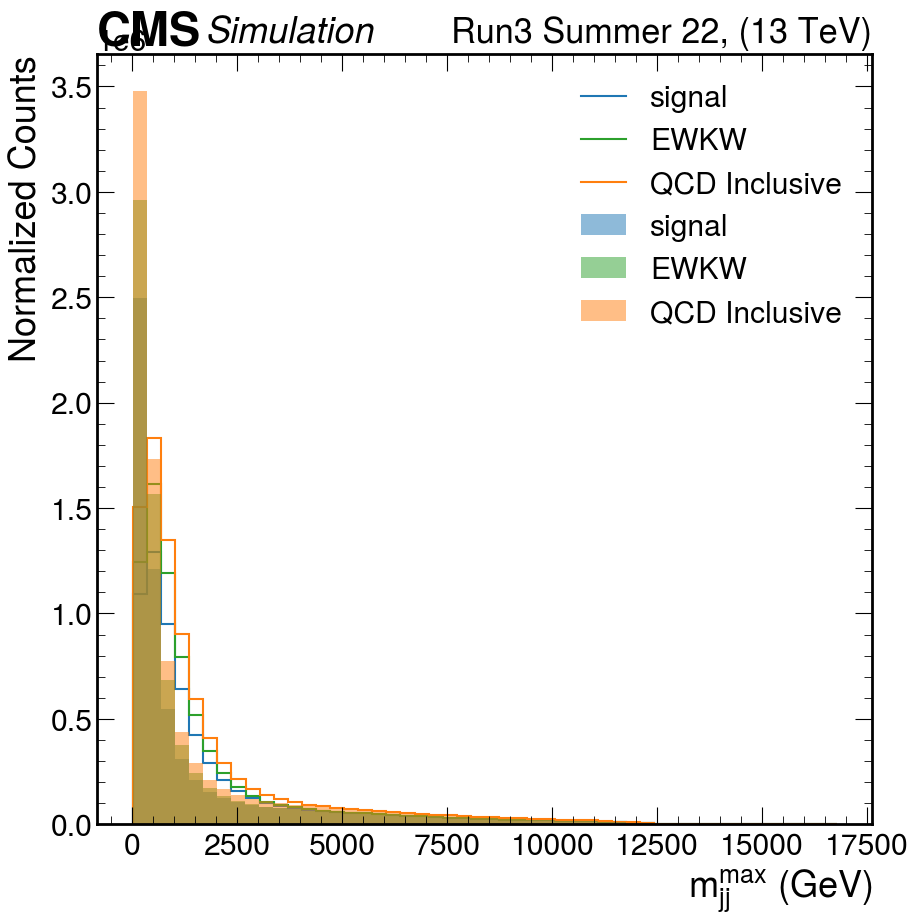

In [316]:
# Plotting for mjj
plt.figure()
sigMAXhist, sigMAXbins = np.histogram(sigmaxmjjs, bins=50)
ewkMAXhist, ewkMAXbins = np.histogram(ewkmaxmjjs, bins=50)
qcdMAXhist, qcdMAXbins = np.histogram(qcdmaxmjjs, bins=50)
sigVBFhist, sigVBFbins = np.histogram(sigVBFmjjs, bins=50)
ewkVBFhist, ewkVBFbins = np.histogram(ewkVBFmjjs, bins=50)
qcdVBFhist, qcdVBFbins = np.histogram(qcdVBFmjjs, bins=50)
plt.style.use(hep.style.CMS)
hep.histplot(sigMAXhist, sigMAXbins, histtype='step', label='signal',        color='tab:blue',   density=False)
hep.histplot(ewkMAXhist, ewkMAXbins, histtype='step', label='EWKW',          color='tab:green',  density=False)
hep.histplot(qcdMAXhist, qcdMAXbins, histtype='step', label='QCD Inclusive', color='tab:orange', density=False)
hep.histplot(sigVBFhist, sigVBFbins, histtype='fill', label='signal',        color='tab:blue',   density=False, alpha=0.5)
hep.histplot(ewkVBFhist, ewkVBFbins, histtype='fill', label='EWKW',          color='tab:green',  density=False, alpha=0.5)
hep.histplot(qcdVBFhist, qcdVBFbins, histtype='fill', label='QCD Inclusive', color='tab:orange', density=False, alpha=0.5)

hep.cms.text("Simulation")
hep.cms.lumitext(r"Run3 Summer 22, (13 TeV)")
plt.title("")
plt.xlabel(r"$m_{jj}^{max}$ (GeV)")
plt.ylabel(r"Normalized Counts")
plt.legend()

In [ ]:
# plotting for delta eta